# Triaxial $\theta_E$ VS spherical $\theta_E$ for a selected sample from the TNG100 simulation - results

Data: a selected sample from the TNG100 catalog and a selected sample from the TNG50 catalog.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from copy import deepcopy
import corner

from cycler import cycler
import matplotlib as mpl
clist = ['#04B2D9', '#F2B33D', '#F29966', '#F2441D', '#0486C5']
mpl.rcParams['axes.prop_cycle'] = cycler(color=clist)

from deproject.Cosmo.default_cosmo import get_default_lens_cosmo

## Access data

In [2]:
data_oblate = np.load('./data_tng100_rmproj_oblate.npy')
data_prolate = np.load('./data_tng100_rmproj_prolate.npy')

# use default cosmology
lens_cosmo = get_default_lens_cosmo()

# add sigma bias
def add_sigma_bias(data, lens_cosmo):
    # compute bias in sigma_sis
    sigma_sis = lens_cosmo.sis_theta_E2sigma_v(theta_E = data[1, :])
    bias_sigma = sigma_sis / data[0, :] - 1
    data = np.insert(data, 2, bias_sigma, axis=0)
    return data

data_oblate = add_sigma_bias(data_oblate, lens_cosmo)
data_prolate = add_sigma_bias(data_prolate, lens_cosmo)

## plot full data

In [3]:
def corner_plot_data(data):
    
    data_plot = deepcopy(data)
    data_plot[4, :] = np.cos(data_plot[4, :])

    hist2dkwargs = {'plot_density':False, 'plot_contours':False, 'plot_datapoints': True, 'color': 'green', 'data_kwargs': {'ms': 4}}

    fig = corner.corner(data_plot.T,  labels=[r'$\sigma_\mathrm{random}$',r'$\theta_E$', r'$b_\sigma$','e', r'$\cos\theta$', r'$\phi$'], label_kwargs={'fontsize': 24}, **hist2dkwargs, hist_kwargs={'linewidth': 2, 'density' : True})

    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=18)

    plt.show()

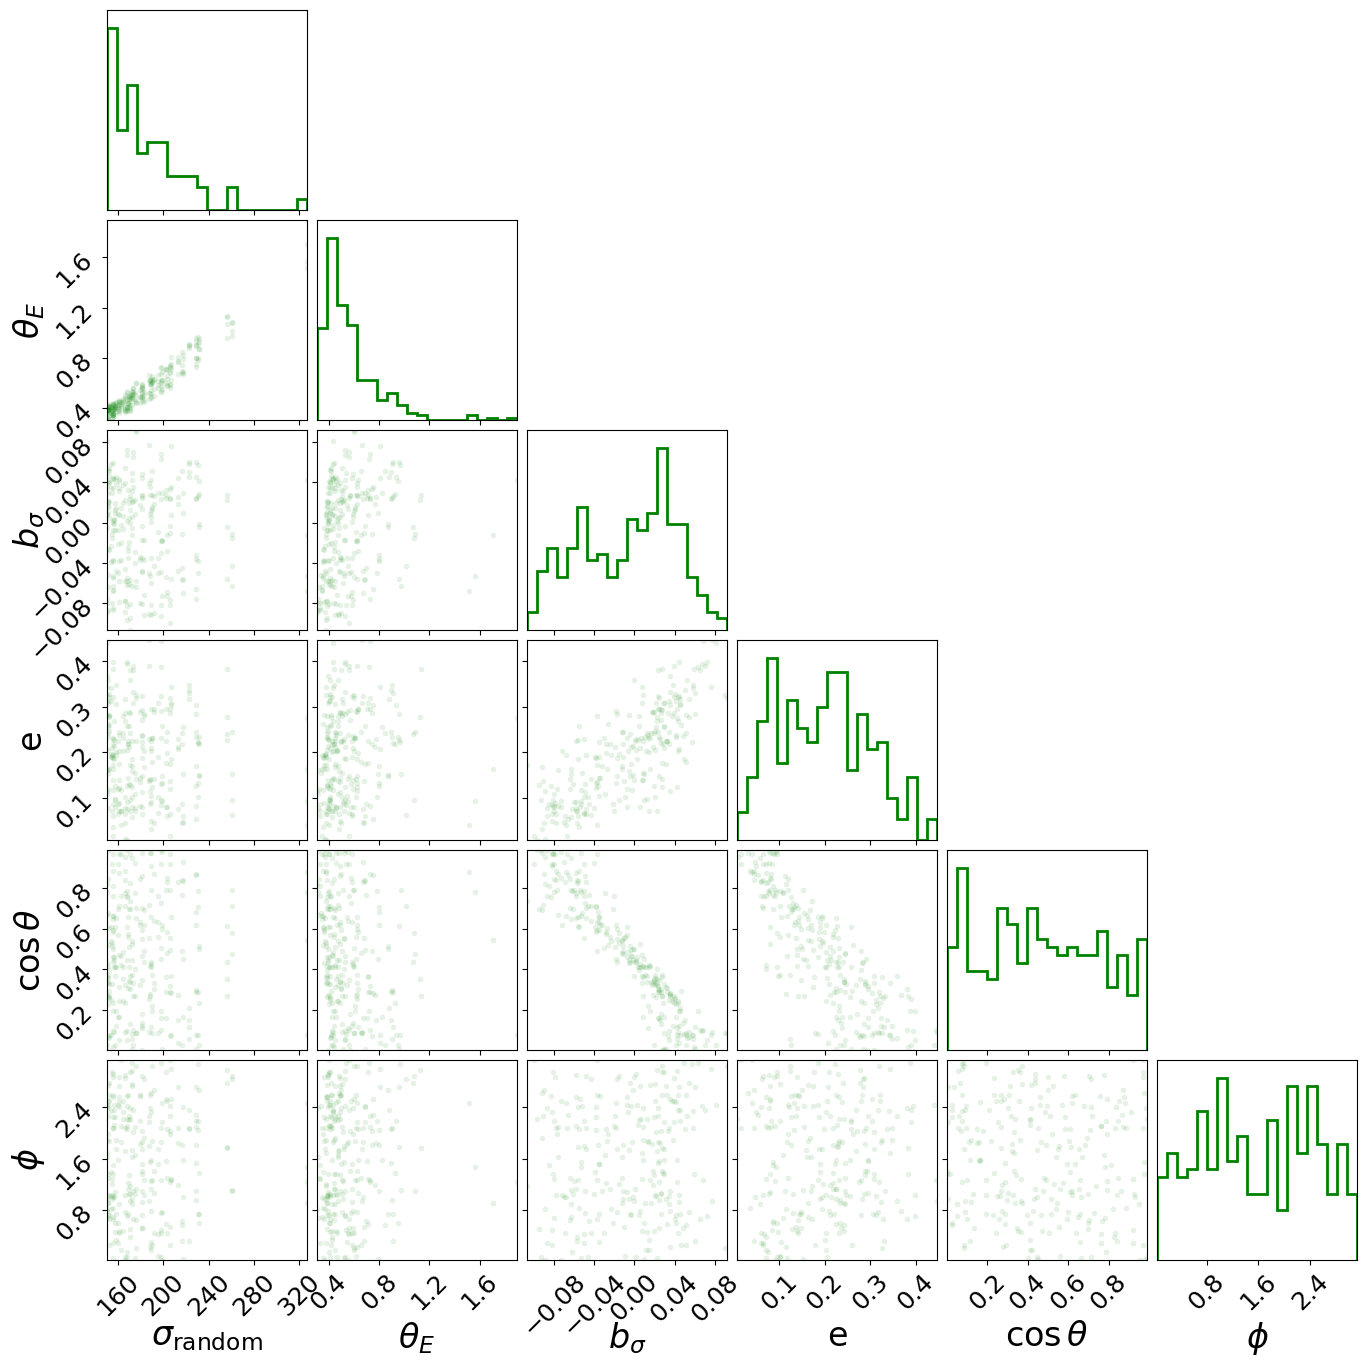

In [4]:
corner_plot_data(data_oblate)

## Plot lensing cut

In [5]:
def corner_plot_with_cut(data, theta_e_cut):

    data_plot = deepcopy(data)
    data_plot[4] = np.cos(data_plot[4])

    color_all = clist[0]
    color_cut = clist[1]

    hist2dkwargs = {'plot_density':False, 'plot_contours':False, 'plot_datapoints': True, 'color': color_all, 'data_kwargs': {'ms': 5, 'alpha': 0.2}}

    fig = corner.corner(data_plot.T,  labels=[r'$\sigma_\mathrm{rm}$ [km/s]',r'$\theta_E$ [arcsec]', r'$b_\sigma$','e', r'$\cos\theta$', r'$\phi$'], label_kwargs={'fontsize': 24}, **hist2dkwargs, hist_kwargs={'linewidth': 2, 'density' : True})

    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=16)

    theta_e_list = data_plot[1, :]
    ind = theta_e_list >= theta_e_cut
    cut_data = data_plot[:, ind]

    cut_hist2dkwargs = {'plot_density':False, 'plot_contours':False, 'plot_datapoints': True, 'color': color_cut, 'data_kwargs': {'ms': 5, 'alpha': 0.3}}

    corner.corner(cut_data.T, fig=fig, **cut_hist2dkwargs, hist_kwargs={'linewidth': 2, 'density' : True})

    mean_bias = np.mean(data[2, :])
    mean_bias_cut = np.mean(cut_data[2, :])
    
    axes = np.array(fig.axes).reshape((6, 6))
    line_bias = axes[2, 2].axvline(mean_bias, color=color_all, linewidth = 2, ls = '--', label = r'mean bias $\langle b_\sigma \rangle$', marker = ' ')
    line_bias_cut = axes[2, 2].axvline(mean_bias_cut, color=color_cut, linewidth = 2, ls = '--', label = r"$\langle b_\sigma \rangle$ with $\theta_E \geq {:.2f}$" .format(theta_e_cut) + "\"" + ' cut', marker = ' ')

    dummy_line1, = axes[0, 0].plot([], [], lw=2, ls='-', color=color_all, label = 'random projection', marker = ' ')
    dummy_line2, = axes[0, 0].plot([], [], lw=2, ls='-', color=color_cut, label = r"with $\theta_E \geq {:.2f}$" .format(theta_e_cut) + "\"" + " cut", marker = ' ')

    fig.legend(handles=[dummy_line1, dummy_line2, line_bias, line_bias_cut], bbox_to_anchor=(0., 0.9, 0.95 ,0), fontsize=24, frameon=False)

    return fig

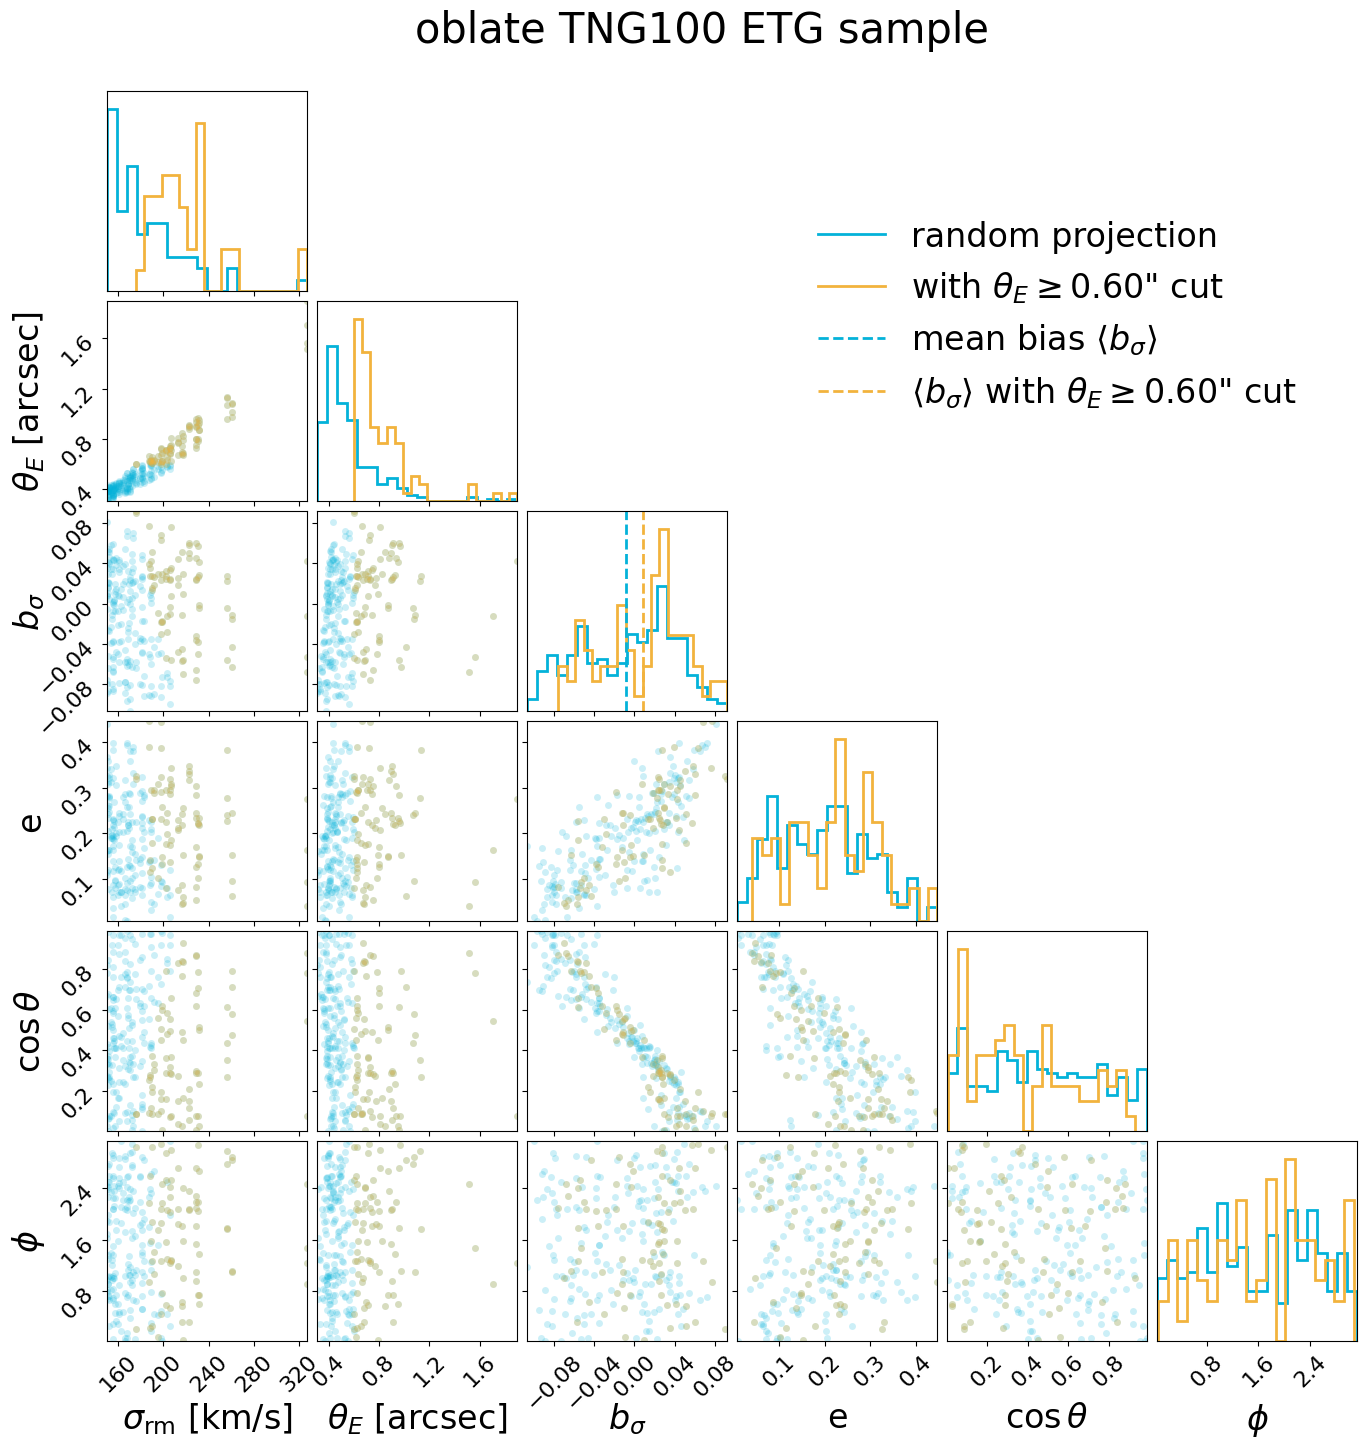

In [6]:
fig = corner_plot_with_cut(data_oblate, 0.6)
fig.suptitle('oblate TNG100 ETG sample', size=30, y=1.03)
# plt.savefig('./data_lensing_selection/tng100_rmproj_oblate.pdf', dpi=300, bbox_inches='tight')

plt.show()

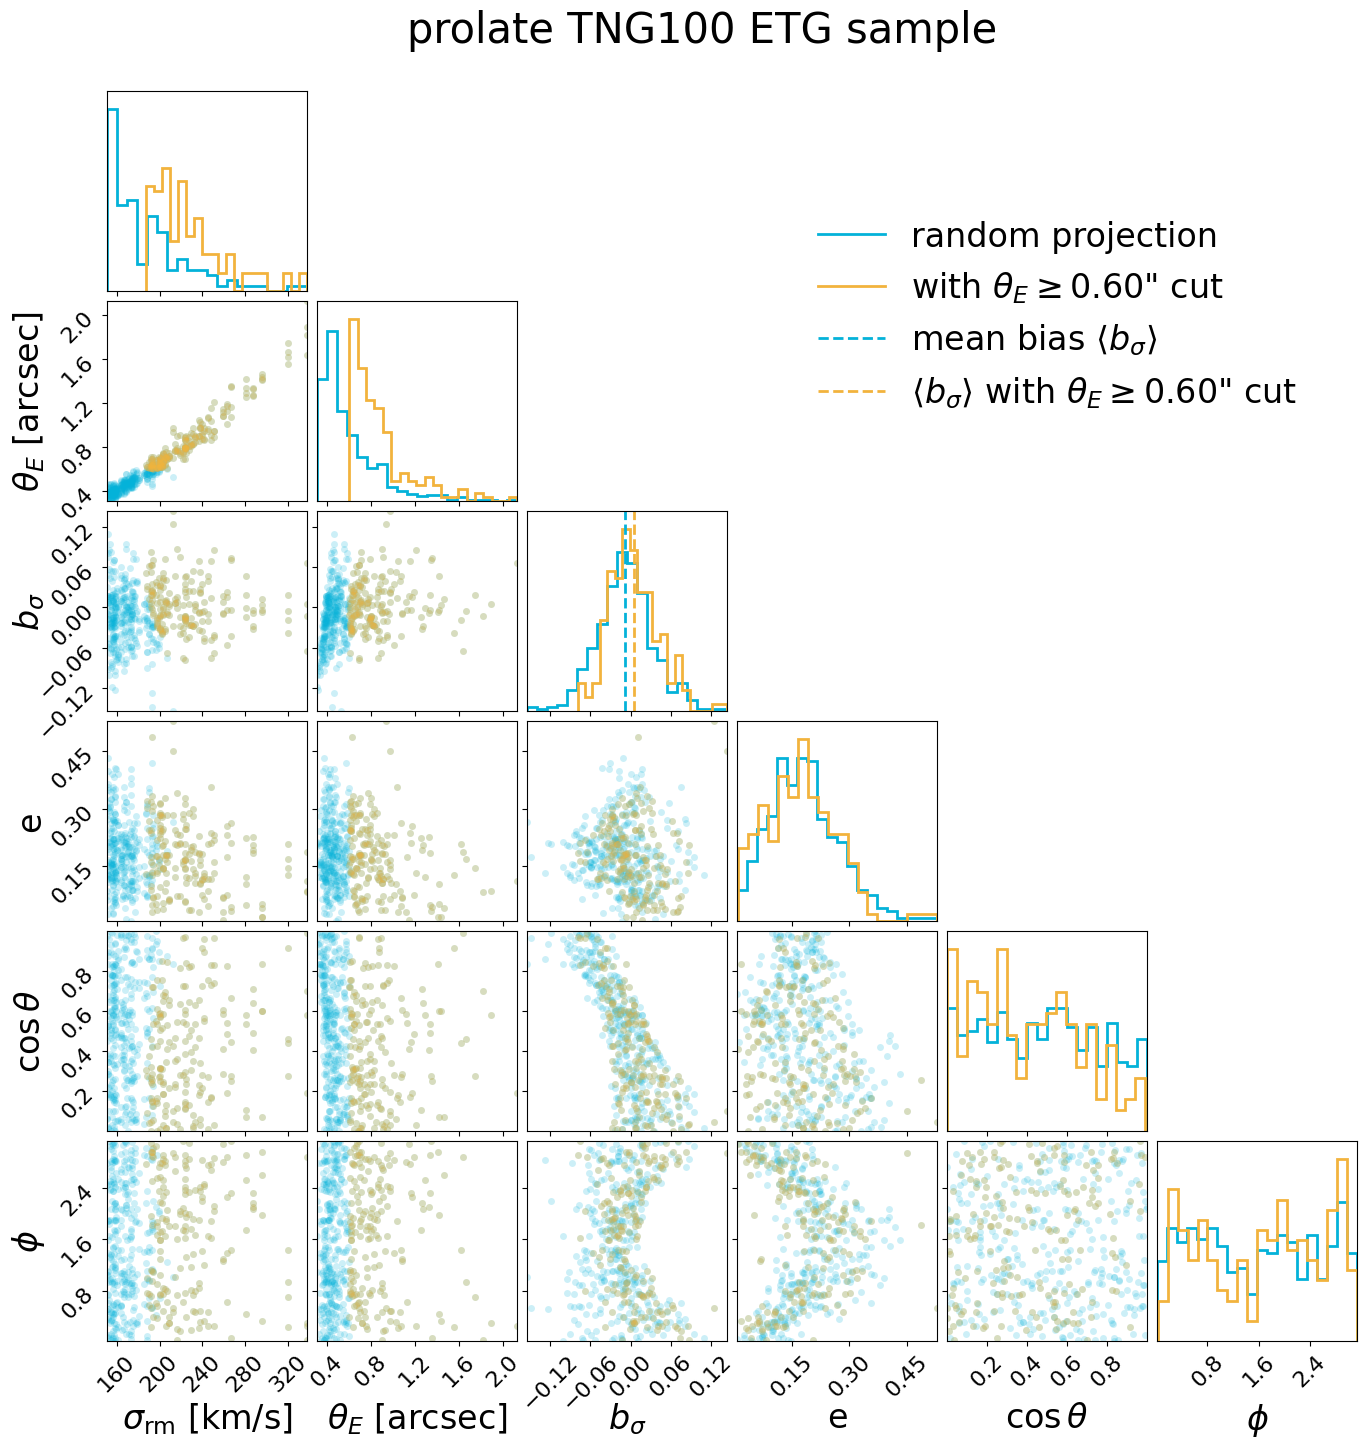

In [7]:
fig = corner_plot_with_cut(data_prolate, 0.6)
fig.suptitle('prolate TNG100 ETG sample', size=30, y=1.03)

plt.show()

In [8]:
data_all = np.concatenate((data_oblate, data_prolate), axis=1)

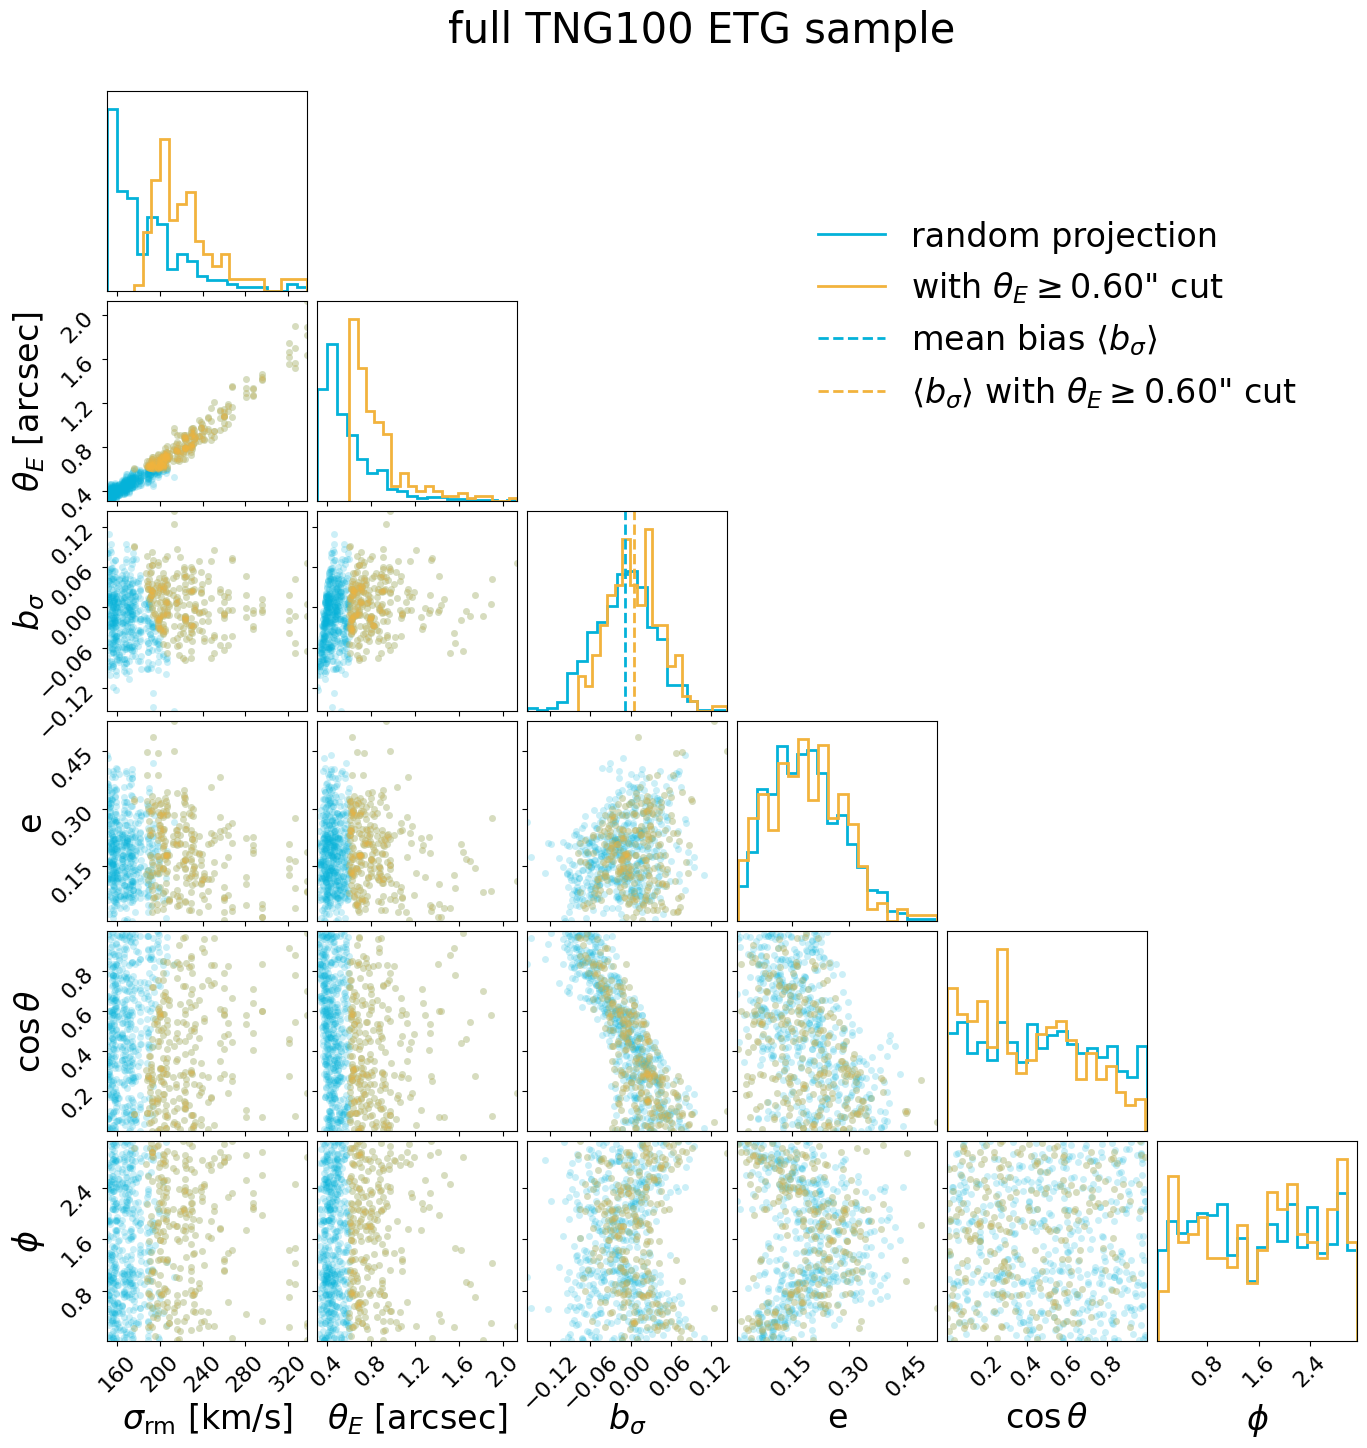

In [9]:
fig = corner_plot_with_cut(data_all, 0.6)
fig.suptitle('full TNG100 ETG sample', size=30, y=1.03)
# plt.savefig('./data_lensing_selection/tng100_rmproj_all.pdf', dpi=300, bbox_inches='tight')

plt.show()

## Calculate the scatter introduced by the projection effect

Quantify the scatter using: 
\begin{equation}
    \sum_j^M \left[\sqrt{\frac{\sum^N_i (\theta_{E, ij} - \langle \theta_{E,j} \rangle)^2}{(N-1)}}/ {\langle \theta_{E,j} \rangle}\right] \frac{1}{M}
\end{equation}
in percentage. $i$ represents each projection. Here $N=4$. $j$ represents each individual lens. 

In [10]:
theta_E_full = data_all[1, :]
theta_E_full = np.reshape(theta_E_full, (191, 4))
theta_E_mean = np.mean(theta_E_full, axis = 1)
# theta_E_var = np.var(theta_E_full, axis=1, ddof=1, dtype=np.float64)
theta_E_std = np.std(theta_E_full, axis=1, ddof=1, dtype=np.float64)
theta_E_scatter = theta_E_std / theta_E_mean
theta_E_scatter_mean = np.mean(theta_E_scatter)

print("mean scatter due to the projection effect: {:.3f} %" .format(theta_E_scatter_mean * 100))

mean scatter due to the projection effect: 7.802 %
